In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
import torch
import random
from pathlib import Path
from config import *
from load_utils import *
from lstm_utils import *

import numpy as np
import platform
import json

architecture='lstm_ae'

In [5]:
exp_dict = exp_name_folders(path =esa_exploration, architecture='lstm_ae')
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:third_wheel_extended_params_sl_100
num selection:1 - exp name:4_wheel_system_lstm_ae_sl_30_run1
num selection:2 - exp name:4_wheel_system_extended_params_sl_16
num selection:3 - exp name:4_wheel_system_extended_params_sl_100
num selection:4 - exp name:third_wheel_lstm_extended_params_sl_30_run_1


In [6]:
select_exp = '1'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: 4_wheel_system_lstm_ae_sl_30_run1


In [7]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm_ae/4_wheel_system_lstm_ae_sl_30_run1/summary.csv


In [8]:
summary.drop(columns = ['train_loss']).reset_index().head()

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,39,31,"trainLSTMAE_30756_00001_1_activation=None,batc...",302476,0.008868,0.008751
1,38,35,"trainLSTMAE_30756_00005_5_activation=None,batc...",217696,0.010696,0.010793
2,37,13,"trainLSTMAE_30756_00014_14_activation=None,bat...",239916,0.010136,0.010852
3,36,30,"trainLSTMAE_30756_00017_17_activation=None,bat...",239916,0.010612,0.010893
4,35,26,"trainLSTMAE_30756_00002_2_activation=None,batc...",235896,0.010821,0.012382
5,34,4,"trainLSTMAE_30756_00018_18_activation=None,bat...",313336,0.010822,0.012591
6,33,3,"trainLSTMAE_30756_00012_12_activation=None,bat...",210016,0.013246,0.014862
7,32,6,"trainLSTMAE_30756_00036_36_activation=None,bat...",203576,0.013647,0.015912
8,31,0,"trainLSTMAE_30756_00013_13_activation=None,bat...",347616,0.023290,0.025977
9,30,19,"trainLSTMAE_30756_00019_19_activation=None,bat...",347616,0.023290,0.025977


In [9]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'None', 'batch_size': 500, 'embedding_dim': 48, 'epochs': 200, 'latent_dim': 60, 'lr': 0.001, 'lr_patience': 5, 'n_layers_cell_1': 2, 'n_layers_cell_2': 1, 'seq_in_length': 30}


In [10]:
try:
    sm = str(torch.cuda.get_device_capability())
    sm = ''.join((sm.strip('()').split(',')[0], sm.strip('()').split(',')[1])).replace(' ', '')
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda and sm in torch.cuda.get_arch_list() else "cpu")
except:
    device='cpu'

/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))
/home/robertomorelli/anaconda3/envs/fdir/lib/python3.8/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX TITAN Black which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


In [11]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path), map_location=device)
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [12]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    

In [14]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 300
random shift 61752


In [15]:
try:
    model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
            n_features=params_conf['n_features'], output_size=params_conf['output_size'],
            embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                    n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2'])
except:
    model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers_1=params_conf['n_layers'], n_layers_2=params_conf['n_layers'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
print('parameters number', count_parameters(model))

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 96, num_layers=2, batch_first=True)
    (LSTM1): LSTM(96, 48, batch_first=True)
    (enc): Linear(in_features=48, out_features=60, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(60, 48, batch_first=True)
    (LSTM1): LSTM(48, 96, num_layers=2, batch_first=True)
    (fc): Linear(in_features=96, out_features=16, bias=True)
  )
)
parameters number 302476


In [16]:
x, enc, yo = model(x.to(device))

In [17]:
path = './figure_results/{}/{}/'.format(model_results_path, shift)
par_nums=count_parameters(model)
print(path)
save = False

./figure_results//srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm_ae/4_wheel_system_lstm_ae_sl_30_run1/61752/


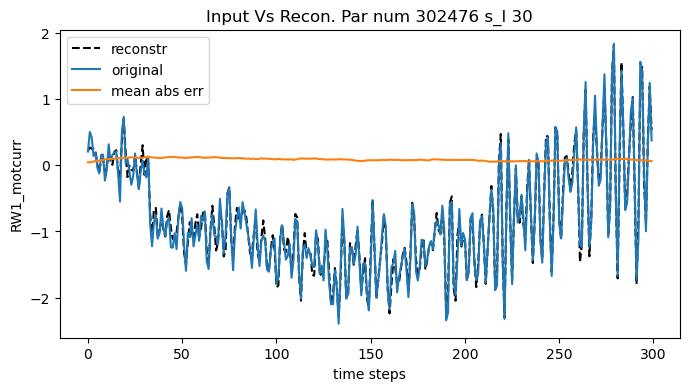

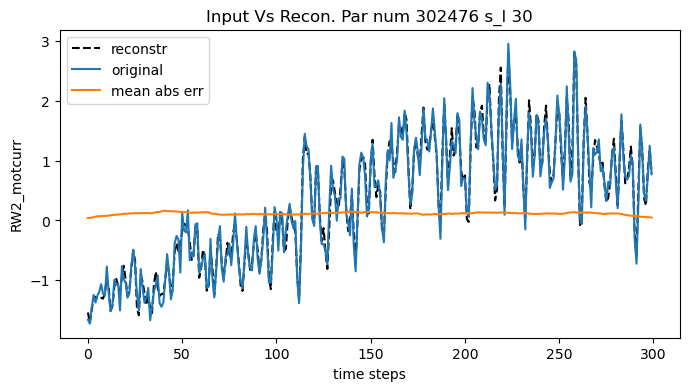

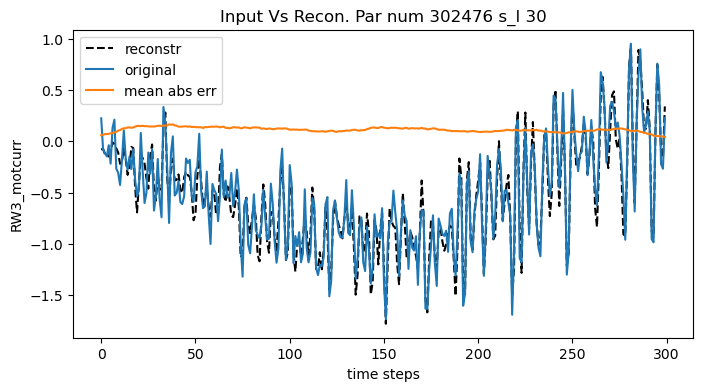

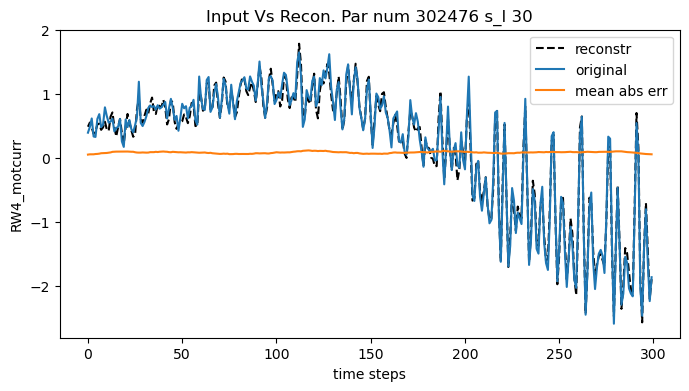

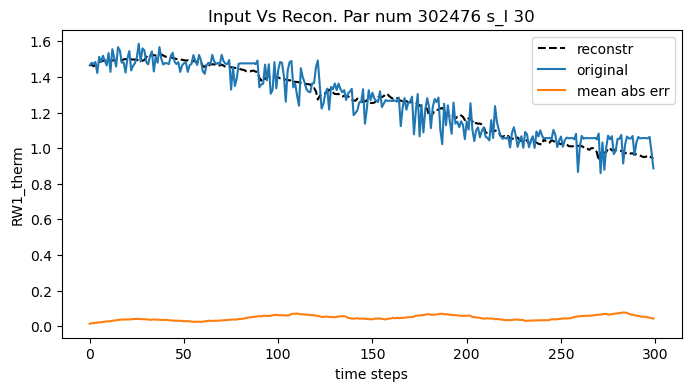

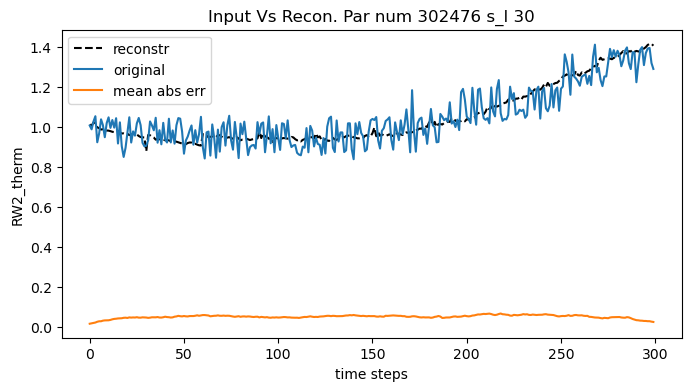

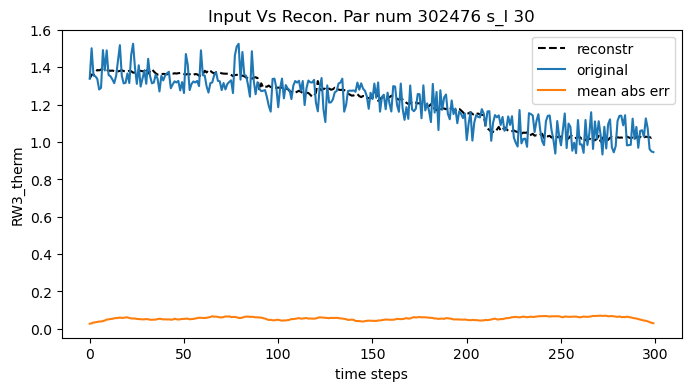

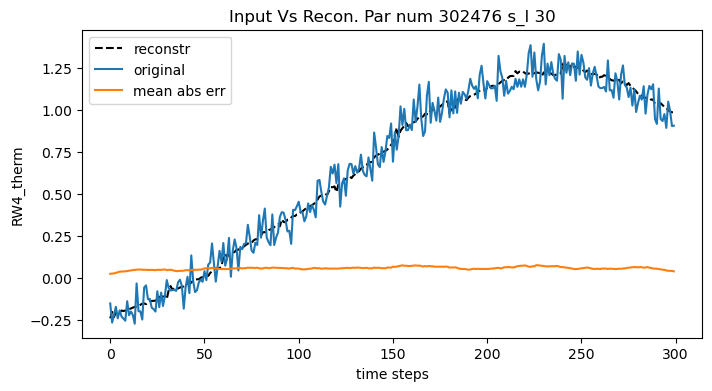

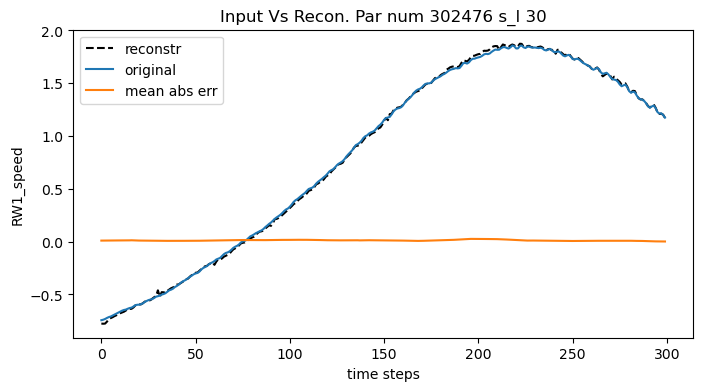

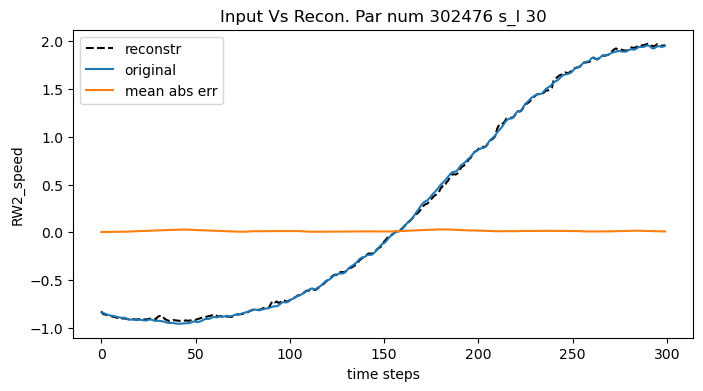

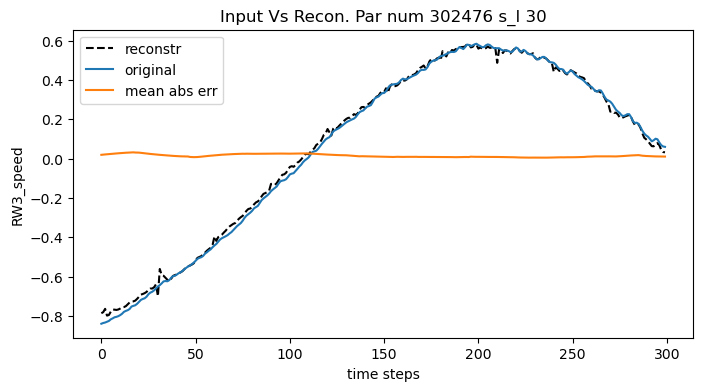

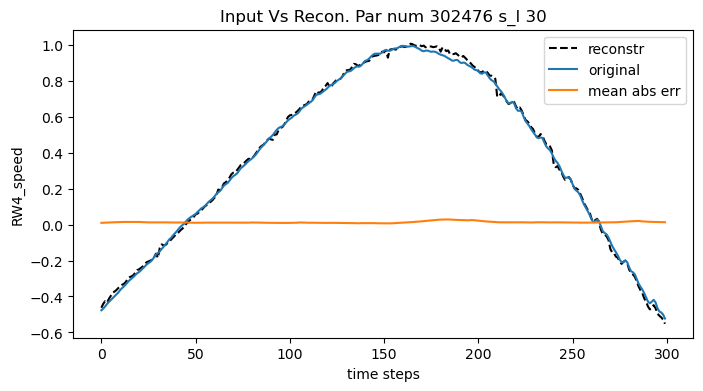

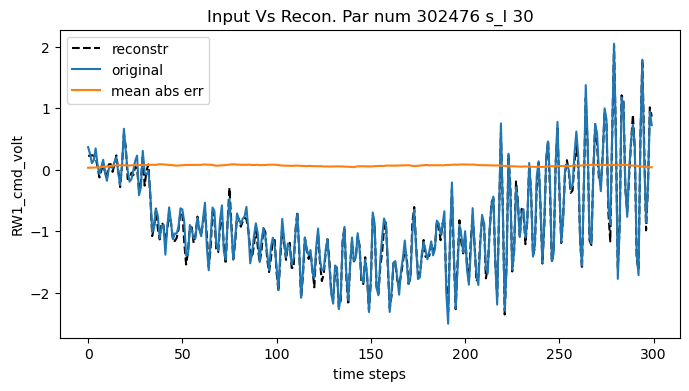

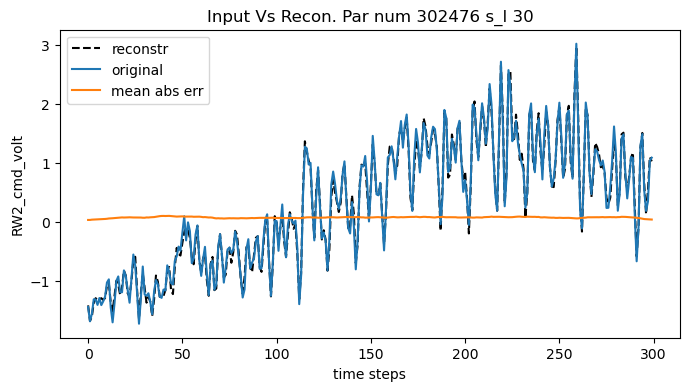

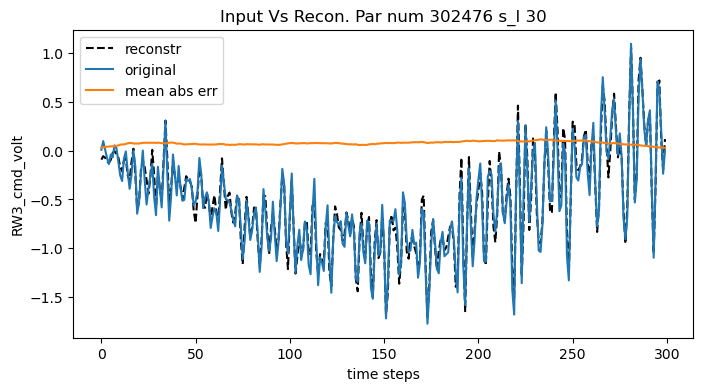

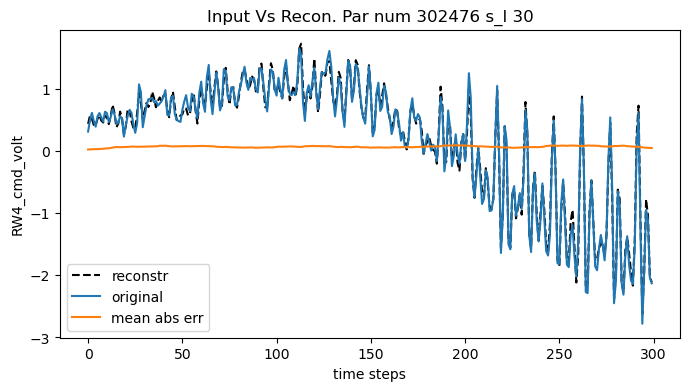

In [18]:
show_results(x,yo,checkpoint['cfg']['dataset']['columns'],
    model_name,params_conf,
    par_nums,shift,num_batch,
    architecture='lstm_ae',
    save=False)